# Comparing tf_pcqsdhc to hapi.py functions

In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from MATSgp.hapi import cpf3, cef, hum1_wei, pcqsdhc
from MATSgp import tf_pcqsdhc
from MATSgp.lineshape_meanfuncs import lineshape_from_dataframe

import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [2]:
dat_files = glob.glob('../Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files.sort()
dat_files

['../Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv']

In [3]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In [4]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800
    d[:, 1] = np.average(d[:, 1]) + 273.15
    d[:, 2] = np.average(d[:, 2]) / 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

dat_y = [d[:, 9] for d in dat]

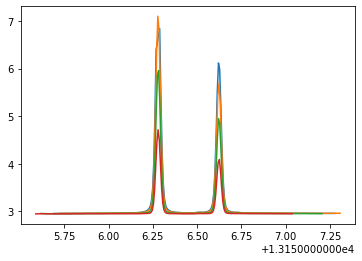

In [5]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], dat_y[i])
plt.show()

In [11]:
noise_scale = 10.0*np.average([np.std(dat_y[i][:10]) for i in range(len(dat_y))])
print(noise_scale)

line_list = []
lineparam_list = pd.read_csv('Parameter_LineList.csv', index_col=0)
for i, line in lineparam_list.iterrows():
    #if i == 13:
    line_list.append(lineshape_from_dataframe(line,
                                             limit_factor_dict={'SD_gamma_air':('factor', 2.0),
                                                                'nu':('magnitude', 0.1),
                                                                'sw':('factor', 2.0)},
                                             line_kwargs={'cutoff':25,
                                                          'noise_scale_factor':noise_scale,
                                                          'mole_fraction':0.01949,
                                                          'fittable':(line['sw'] >= 1.0)}
                                            ))

0.008708101055790094


In [12]:
wave = x[3][:, 0]
T = x[3][:, 1]
P = x[3][:, 2]
dInds = np.array(x[3][:, 3], dtype=np.int32)

In [13]:
mol_dens = (P / 9.869233e-7) / (1.380648813e-16 * T)

In [14]:
dset_param_list = ["nu", "sw", "gamma0", "delta0", "sd_gamma", "sd_delta", "nuvc", "eta", "y"]

out_ref = 0.0
out = 0.0

for lineshape in line_list:
    nu, sw, gamma0, delta0, sd_gamma, sd_delta, nuVC, eta, y = lineshape.get_dset_params(dInds, dset_param_list)
    y = y * (P/lineshape.Pref)
    line_intensity = lineshape.environmentdependency_intensity(T, nu, sw)
    params = lineshape.get_params_at_TP(T, P, nu, gamma0, delta0, sd_gamma, sd_delta, nuVC, eta)
    ref = pcqsdhc(nu[0].numpy(), *[p[0].numpy() for p in params], wave)
    vals = tf_pcqsdhc.tf_pcqsdhc(nu, *params, wave)
    #plt.plot(wave, tf.math.real(vals[2][9] - ref[2][9]))
    #plt.plot(wave, tf.math.real(vals[2][3] - ref[2][3]))
    out_ref += mol_dens * lineshape.mole_frac * line_intensity * (ref[0] + y * ref[1]) * 1e06
    out += mol_dens * lineshape.mole_frac * line_intensity * (vals[0] + y * vals[1]) * 1e06


<IPython.core.display.Javascript object>


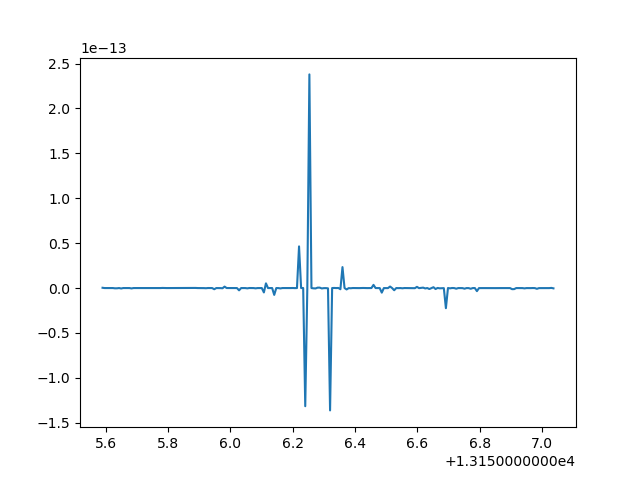

In [15]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(wave, (out - out_ref))#/out_ref)

plt.show()

In [121]:
test_real = -tf.math.imag(vals[2][6]) #np.random.normal(size=(10)) / 100.0
test_imag = tf.math.real(vals[2][6]) #np.random.random(size=(10)) / 100.0

test_real_ref = -tf.math.imag(ref[2][6]) #np.random.normal(size=(10)) / 100.0
test_imag_ref = tf.math.real(ref[2][6]) #np.random.random(size=(10)) / 100.0

tf_pcqsdhc.cpf3(test_real, test_imag) - tf.complex(*cpf3(test_real, test_imag))

<tf.Tensor: shape=(1, 215), dtype=complex128, numpy=
array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00-1.73472348e-18j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.71050543e-20+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00-1.73472348e-18j, -2.71050543e-20+1.73472348e-18j,
         2.71050543e-20-3.46944695e-18j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -2.71050543e-20+0.00000000e+00j,  2.71050543e-20+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.71050543e-20-3.46944695e-18j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00-1.73472348e-18j,
         2.71050543e-20-1.73472348e-18j,  0.00000000e+00+0.

In [122]:
tf_pcqsdhc.cpf3(test_real, test_imag)

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([ 1.23083408e-04-9.42974743e-03j,  1.23210799e-04-9.49069757e-03j,
        1.23340675e-04-9.55244121e-03j,  1.23473101e-04-9.61499393e-03j,
        1.23608145e-04-9.67837177e-03j,  1.23745877e-04-9.74259113e-03j,
        1.23886369e-04-9.80766891e-03j,  1.24029695e-04-9.87362242e-03j,
        1.24175933e-04-9.94046947e-03j,  1.24325163e-04-1.00082283e-02j,
        1.24477466e-04-1.00769178e-02j,  1.24632929e-04-1.01465572e-02j,
        1.24791640e-04-1.02171663e-02j,  1.24953690e-04-1.02887656e-02j,
        1.25119175e-04-1.03613759e-02j,  1.25288191e-04-1.04350190e-02j,
        1.25460841e-04-1.05097170e-02j,  1.25637231e-04-1.05854927e-02j,
        1.25817469e-04-1.06623696e-02j,  1.26001668e-04-1.07403718e-02j,
        1.26189946e-04-1.08195244e-02j,  1.26382426e-04-1.08998529e-02j,
        1.26579232e-04-1.09813837e-02j,  1.26780496e-04-1.10641440e-02j,
        1.26986354e-04-1.11481619e-02j,  1.27196949e-04-1.12334663e-02j,


In [123]:
tf.complex(*cpf3(test_real, test_imag))

<tf.Tensor: shape=(1, 215), dtype=complex128, numpy=
array([[ 1.23083408e-04-9.42974743e-03j,  1.23210799e-04-9.49069757e-03j,
         1.23340675e-04-9.55244121e-03j,  1.23473101e-04-9.61499393e-03j,
         1.23608145e-04-9.67837177e-03j,  1.23745877e-04-9.74259113e-03j,
         1.23886369e-04-9.80766891e-03j,  1.24029695e-04-9.87362242e-03j,
         1.24175933e-04-9.94046947e-03j,  1.24325163e-04-1.00082283e-02j,
         1.24477466e-04-1.00769178e-02j,  1.24632929e-04-1.01465572e-02j,
         1.24791640e-04-1.02171663e-02j,  1.24953690e-04-1.02887656e-02j,
         1.25119175e-04-1.03613759e-02j,  1.25288191e-04-1.04350190e-02j,
         1.25460841e-04-1.05097170e-02j,  1.25637231e-04-1.05854927e-02j,
         1.25817469e-04-1.06623696e-02j,  1.26001668e-04-1.07403718e-02j,
         1.26189946e-04-1.08195244e-02j,  1.26382426e-04-1.08998529e-02j,
         1.26579232e-04-1.09813837e-02j,  1.26780496e-04-1.10641440e-02j,
         1.26986354e-04-1.11481619e-02j,  1.27196949e-04-1.

In [124]:
tf_pcqsdhc.cef(test_real, test_imag, 24) - cef(test_real.numpy(), test_imag.numpy(), 24)

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([-1.08420217e-19+1.73472348e-18j,  0.00000000e+00+0.00000000e+00j,
       -2.16840434e-19+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        4.33680869e-19+0.00000000e+00j, -4.33680869e-19+1.73472348e-18j,
       -2.16840434e-19+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -1.08420217e-19+0.00000000e+00j, -1.08420217e-19+0.00000000e+00j,
        0.00000000e+00-1.73472348e-18j,  1.08420217e-19+0.00000000e+00j,
       -1.08420217e-19+0.00000000e+00j,  0.00000000e+00+1.73472348e-18j,
        0.00000000e+00+0.00000000e+00j,  1.08420217e-19+0.00000000e+00j,
       -2.16840434e-19+1.73472348e-18j,  1.08420217e-19-1.73472348e-18j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        3.25260652e-19+0.00000000e+00j, -1.08420217e-19+0.00000000e+00j,
        6.50521303e-19-1.73472348e-18j,  1.08420217e-19+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,


In [125]:
tf_pcqsdhc.cef(test_real, test_imag, 24)

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([1.23083409e-04-0.00942975j, 1.23210799e-04-0.0094907j ,
       1.23340675e-04-0.00955244j, 1.23473101e-04-0.00961499j,
       1.23608146e-04-0.00967837j, 1.23745877e-04-0.00974259j,
       1.23886369e-04-0.00980767j, 1.24029696e-04-0.00987362j,
       1.24175934e-04-0.00994047j, 1.24325163e-04-0.01000823j,
       1.24477467e-04-0.01007692j, 1.24632930e-04-0.01014656j,
       1.24791640e-04-0.01021717j, 1.24953691e-04-0.01028877j,
       1.25119175e-04-0.01036138j, 1.25288191e-04-0.01043502j,
       1.25460842e-04-0.01050972j, 1.25637231e-04-0.01058549j,
       1.25817469e-04-0.01066237j, 1.26001668e-04-0.01074037j,
       1.26189947e-04-0.01081952j, 1.26382426e-04-0.01089985j,
       1.26579232e-04-0.01098138j, 1.26780496e-04-0.01106414j,
       1.26986355e-04-0.01114816j, 1.27196949e-04-0.01123347j,
       1.27632937e-04-0.01140805j, 1.27858642e-04-0.0114974j ,
       1.28089706e-04-0.01158816j, 1.28326299e-04-0.01168036j,
    

In [126]:
cef(test_real.numpy(), test_imag.numpy(), 24)

array([1.23083409e-04-0.00942975j, 1.23210799e-04-0.0094907j ,
       1.23340675e-04-0.00955244j, 1.23473101e-04-0.00961499j,
       1.23608146e-04-0.00967837j, 1.23745877e-04-0.00974259j,
       1.23886369e-04-0.00980767j, 1.24029696e-04-0.00987362j,
       1.24175934e-04-0.00994047j, 1.24325163e-04-0.01000823j,
       1.24477467e-04-0.01007692j, 1.24632930e-04-0.01014656j,
       1.24791640e-04-0.01021717j, 1.24953691e-04-0.01028877j,
       1.25119175e-04-0.01036138j, 1.25288191e-04-0.01043502j,
       1.25460842e-04-0.01050972j, 1.25637231e-04-0.01058549j,
       1.25817469e-04-0.01066237j, 1.26001668e-04-0.01074037j,
       1.26189947e-04-0.01081952j, 1.26382426e-04-0.01089985j,
       1.26579232e-04-0.01098138j, 1.26780496e-04-0.01106414j,
       1.26986355e-04-0.01114816j, 1.27196949e-04-0.01123347j,
       1.27632937e-04-0.01140805j, 1.27858642e-04-0.0114974j ,
       1.28089706e-04-0.01158816j, 1.28326299e-04-0.01168036j,
       1.28568601e-04-0.01177404j, 1.28816797e-04-0.011

In [127]:
tf_pcqsdhc.hum1_wei(test_real, test_imag) - tf.complex(*hum1_wei(test_real.numpy(), test_imag.numpy()))

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  5.42101086e-20-3.46944695e-18j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00-1.73472348e-18j,
       -2.71050543e-20+0.00000000e+00j,  0.00000000e+00+1.73472348e-18j,
        0.00000000e+00+1.73472348e-18j,  2.71050543e-20-3.46944695e-18j,
        0.00000000e+00-1.73472348e-18j, -2.71050543e-20+0.00000000e+00j,
        2.71050543e-20+1.73472348e-18j,  2.71050543e-20+0.00000000e+00j,
       -8.13151629e-20+1.73472348e-18j,  0.00000000e+00+1.73472348e-18j,
       -2.71050543e-20-1.73472348e-18j,  0.00000000e+00+1.73472348e-18j,
       -2.71050543e-20+1.73472348e-18j, -2.71050543e-20+0.00000000e+00j,
       -2.71050543e-20+1.73472348e-18j, -2.71050543e-20+1.73472348e-18j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        2.71050543e-20+1.73472348e-18j,  2.71050543e-20+1.73472348e-18j,


In [128]:
tf_pcqsdhc.hum1_wei(test_real, test_imag)

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([1.23083384e-04-0.00942975j, 1.23210774e-04-0.0094907j ,
       1.23340650e-04-0.00955244j, 1.23473075e-04-0.00961499j,
       1.23608118e-04-0.00967837j, 1.23745850e-04-0.00974259j,
       1.23886341e-04-0.00980767j, 1.24029666e-04-0.00987362j,
       1.24175903e-04-0.00994047j, 1.24325132e-04-0.01000823j,
       1.24477435e-04-0.01007692j, 1.24632897e-04-0.01014656j,
       1.24791607e-04-0.01021717j, 1.24953656e-04-0.01028876j,
       1.25119139e-04-0.01036138j, 1.25288154e-04-0.01043502j,
       1.25460804e-04-0.01050972j, 1.25637192e-04-0.01058549j,
       1.25817429e-04-0.01066237j, 1.26001627e-04-0.01074037j,
       1.26189904e-04-0.01081952j, 1.26382382e-04-0.01089985j,
       1.26579186e-04-0.01098138j, 1.26780449e-04-0.01106414j,
       1.26986306e-04-0.01114816j, 1.27196899e-04-0.01123347j,
       1.27632883e-04-0.01140805j, 1.27858587e-04-0.0114974j ,
       1.28089649e-04-0.01158816j, 1.28326240e-04-0.01168036j,
    

In [129]:
tf.complex(*hum1_wei(test_real.numpy(), test_imag.numpy()))

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([1.23083384e-04-0.00942975j, 1.23210774e-04-0.0094907j ,
       1.23340650e-04-0.00955244j, 1.23473075e-04-0.00961499j,
       1.23608118e-04-0.00967837j, 1.23745850e-04-0.00974259j,
       1.23886341e-04-0.00980767j, 1.24029666e-04-0.00987362j,
       1.24175903e-04-0.00994047j, 1.24325132e-04-0.01000823j,
       1.24477435e-04-0.01007692j, 1.24632897e-04-0.01014656j,
       1.24791607e-04-0.01021717j, 1.24953656e-04-0.01028876j,
       1.25119139e-04-0.01036138j, 1.25288154e-04-0.01043502j,
       1.25460804e-04-0.01050972j, 1.25637192e-04-0.01058549j,
       1.25817429e-04-0.01066237j, 1.26001627e-04-0.01074037j,
       1.26189904e-04-0.01081952j, 1.26382382e-04-0.01089985j,
       1.26579186e-04-0.01098138j, 1.26780449e-04-0.01106414j,
       1.26986306e-04-0.01114816j, 1.27196899e-04-0.01123347j,
       1.27632883e-04-0.01140805j, 1.27858587e-04-0.0114974j ,
       1.28089649e-04-0.01158816j, 1.28326240e-04-0.01168036j,
    

In [130]:
tf_pcqsdhc.hum1_wei(test_real, test_imag) - tf_pcqsdhc.hum1_wei(test_real_ref, test_imag_ref)

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([ 7.16657636e-17+1.73472348e-18j,  7.25331253e-17+3.46944695e-18j,
        7.34818022e-17+3.46944695e-18j,  7.45388994e-17-1.73472348e-18j,
        7.55146813e-17+1.73472348e-18j,  7.64904633e-17+1.73472348e-18j,
        7.74662452e-17+3.46944695e-18j,  7.85504474e-17+1.73472348e-18j,
        7.96617546e-17+3.46944695e-18j, -1.08420217e-19+1.73472348e-18j,
        8.18843691e-17-1.73472348e-18j,  8.29685712e-17+0.00000000e+00j,
       -2.71050543e-20+5.20417043e-18j,  8.53809211e-17+1.73472348e-18j,
        8.65193334e-17+3.46944695e-18j,  8.77661659e-17+1.73472348e-18j,
        8.90129984e-17+1.73472348e-18j,  9.02869359e-17+1.73472348e-18j,
       -5.42101086e-20+5.20417043e-18j,  9.29974413e-17+0.00000000e+00j,
       -8.13151629e-20+3.46944695e-18j,  9.57350518e-17+3.46944695e-18j,
        9.71987248e-17+3.46944695e-18j,  9.86352926e-17+3.46944695e-18j,
        1.00153176e-16+3.46944695e-18j,  1.01833689e-16+3.46944695e-18j,


In [54]:
tf.complex(*hum1_wei(test_real.numpy(), test_imag.numpy())) - tf.complex(*hum1_wei(test_real_ref.numpy(), test_imag_ref.numpy()))

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([-1.60705867e-16+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -1.67102660e-16+3.46944695e-18j, -1.70409476e-16+0.00000000e+00j,
       -1.73716293e-16+0.00000000e+00j, -1.77375475e-16+5.20417043e-18j,
       -1.80872027e-16+0.00000000e+00j, -3.69387680e-16+1.73472348e-18j,
       -1.88488548e-16-1.73472348e-18j, -3.85108612e-16+1.73472348e-18j,
       -1.96647169e-16-3.46944695e-18j, -4.01859535e-16+3.46944695e-18j,
       -2.05293681e-16+0.00000000e+00j, -2.09901541e-16+3.46944695e-18j,
       -2.14428085e-16-3.46944695e-18j, -2.19388310e-16+0.00000000e+00j,
       -2.24456955e-16+3.46944695e-18j, -2.29579810e-16-3.46944695e-18j,
       -2.34865296e-16-3.46944695e-18j,  0.00000000e+00+0.00000000e+00j,
       -2.46330734e-16+0.00000000e+00j, -2.52266740e-16+0.00000000e+00j,
       -2.58473798e-16+0.00000000e+00j, -2.64979011e-16+6.93889390e-18j,
       -2.71565539e-16+0.00000000e+00j, -2.78477328e-16-3.46944695e-18j,


In [31]:
np.sqrt(np.log(2.0e0)) / params[2]

<tf.Tensor: shape=(215,), dtype=float64, numpy=
array([269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.11732108, 269309.11732108,
       269309.11732108, 269309.11732108, 269309.1173

In [21]:
ref[2][2]

(3.091446065545228e-06+0j)

In [22]:
vals[2][2]

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09144607e-06+0.j, 3.09144607e-06+0.j, 3.09144607e-06+0.j,
       3.09

In [24]:
1.0e0 / ((2.0e0 * ref[2][0] * ref[2][2])) **2

(7800332.376728715+0j)

In [25]:
1.0e0 / ((2.0e0 * vals[2][0] * vals[2][2])) **2 - 1.0e0 / ((2.0e0 * ref[2][0] * ref[2][2])) **2

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([-2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772e-09+0.j, -2.79396772e-09+0.j,
       -2.79396772e-09+0.j, -2.79396772

In [56]:
1.0e0 / ((2.0e0 * tf.convert_to_tensor(ref[2][0] + 0.0e0j) * tf.convert_to_tensor(ref[2][2]))) **2 - 1.0e0 / ((2.0e0 * ref[2][0] * ref[2][2])) **2

<tf.Tensor: shape=(), dtype=complex128, numpy=(-2.7939677238464355e-09+0j)>

In [40]:
ref[2][0]

57.909761456053026

In [41]:
ref[2][2]

(3.091446065545228e-06+0j)

In [57]:
1.0e0 / ((2.0e0 * tf.cast(ref[2][0], dtype=tf.float64) * tf.cast(ref[2][2].real, dtype=tf.float64))) **2 - 1.0e0 / ((2.0e0 * ref[2][0] * ref[2][2].real)) **2

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [55]:
tf.zeros_like(wave, dtype=tf.complex128)

<tf.Tensor: shape=(215,), dtype=complex128, numpy=
array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+

In [137]:
a = 57.909761456053026
b = 3.091446065545228e-06 + 0.0e0j

result1 = 1.0e0 / tf.square((2.0e0 * tf.constant(a, dtype=tf.complex128) * tf.constant(b, tf.complex128))) - 1.0e0 / ((2.0e0 * a * b))**2
result2 = 1.0e0 / tf.square((2.0e0 * tf.constant(a, dtype=tf.float64) * tf.constant(b.real, dtype=tf.float64))) - 1.0e0 / ((2.0e0 * a * b.real))**2

print(result1, result2)

tf.Tensor(0j, shape=(), dtype=complex128) tf.Tensor(0.0, shape=(), dtype=float64)


In [65]:
result1 = 1.0e0 / ((2.0e0 * tf.cast(ref[2][0], dtype=tf.complex128) * tf.cast(ref[2][2], dtype=tf.complex128))) **2 - 1.0e0 / ((2.0e0 * ref[2][0] * ref[2][2])) **2
result2 = 1.0e0 / ((2.0e0 * tf.cast(ref[2][0], dtype=tf.float64) * tf.cast(ref[2][2].real, dtype=tf.float64))) **2 - 1.0e0 / ((2.0e0 * ref[2][0] * ref[2][2].real)) **2

print(result1, result2)

tf.Tensor((-2.7939677238464355e-09+0j), shape=(), dtype=complex128) tf.Tensor(0.0, shape=(), dtype=float64)


In [76]:
tf.constant(57.909761456053026, dtype=tf.float64) - tf.constant(np.array(57.909761456053026), dtype=tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [149]:
def tf_csqrtY(gam2, shift2, cte, eta):
    numer = tf.complex(gam2, -shift2)
    denom = 2.0e0 * cte * (1.0e0 - tf.cast(eta, tf.complex128)) * tf.cast(tf.square(gam2) + tf.square(shift2), tf.complex128)
    return numer / denom

def tf_csqrtY_alt(gam2, shift2, cte, eta):
    fac = (2.0e0 * tf.cast(cte, tf.float64) * (1.0e0 - eta) * (tf.square(gam2) + tf.square(shift2)))
    return tf.complex(gam2 / fac, -shift2 / fac)
    
def csqrtY(gam2, shift2, cte, eta):
    numer = gam2 - 1.0e0j*shift2
    denom = 2.0e0 * cte * (1.0e0 - eta) * (gam2**2 + shift2**2)
    return numer / denom


In [150]:
print(params[2][0], params[4][0], vals[2][0][0], params[6][0])

tf.Tensor(3.4688409643349974e-06, shape=(), dtype=float64) tf.Tensor(0.0, shape=(), dtype=float64) tf.Tensor((57.90825183465359+0j), shape=(), dtype=complex128) tf.Tensor(0.0, shape=(), dtype=float64)


In [151]:
( 
 tf_csqrtY_alt(params[2][0], params[4][0], ref[2][0], params[6][0])
 - csqrtY(params[2][0].numpy(), params[4][0].numpy(), ref[2][0], params[6][0].numpy())
)

<tf.Tensor: shape=(), dtype=complex128, numpy=-0j>

In [117]:
print(tf_csqrtY(params[2][0], params[4][0], ref[2][0], params[6][0]))
print(csqrtY(params[2][0].numpy(), params[4][0].numpy(), ref[2][0], params[6][0].numpy()))

tf.Tensor((2489.116138847636-0j), shape=(), dtype=complex128)
(2489.1161388476366+0j)


In [102]:
a = np.array(2.0e0 + 3.0e0j)
b = np.array(1.0e0 - 1.5e0j)

print(tf.cast(a, tf.complex128) / tf.cast(b, tf.complex128))
print(a/b)

tf.Tensor((-0.7692307692307693+1.8461538461538463j), shape=(), dtype=complex128)
(-0.7692307692307693+1.8461538461538463j)


In [19]:
def tf_complex_divide(c1, c2):
    numer = c1 * tf.math.conj(c2)
    denom = 1.0 / tf.square(tf.math.real(c2)) + tf.square(tf.math.imag(c2))
    return tf.complex(tf.math.real(numer) * denom, tf.math.imag(numer) * denom)

def tf_csqrtY(gam2, shift2, cte, eta):
    numer = tf.complex(gam2, -shift2)
    denom = 2.0e0 * cte * (1.0e0 - tf.cast(eta, tf.complex128)) * tf.cast(tf.square(gam2) + tf.square(shift2), tf.complex128)
    return tf_complex_divide(numer, denom)

def csqrtY(gam2, shift2, cte, eta):
    numer = gam2 - 1.0e0j*shift2
    denom = 2.0e0 * cte * (1.0e0 - eta) * (gam2**2 + shift2**2)
    return numer / denom

a = np.array(3.4688409643349974e-06)
b = np.array(0.0e+0)
c = np.array(57.90825183465359)
d = np.array(0.0e+0)

print(tf_csqrtY(a, b, c, d) - csqrtY(a, b, c, d))

tf.Tensor((-4.547473508864641e-13-0j), shape=(), dtype=complex128)


# Comparing LineShape to HTP_from_DF_select

In [1]:
import glob
import numpy as np
import pandas as pd

from MATSgp.tf_pcqsdhc import tf_pcqsdhc
from MATSgp.lineshape_meanfuncs import lineshape_from_dataframe
from Fit_Dataset import HTP_from_DF_select

import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
     

In [2]:
dat_files = glob.glob('../Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files.sort()
dat_files

['../Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv']

In [3]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In [4]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800
    d[:, 1] = np.average(d[:, 1]) + 273.15
    d[:, 2] = np.average(d[:, 2]) / 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

dat_y = [d[:, 9] for d in dat]

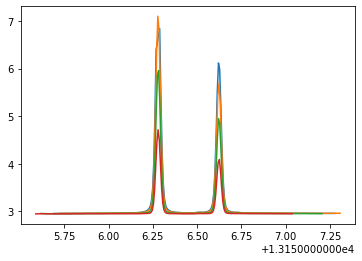

In [5]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], dat_y[i])
plt.show()

In [6]:
noise_scale = 10.0*np.average([np.std(dat_y[i][:10]) for i in range(len(dat_y))])
print(noise_scale)

line_list = []
lineparam_list = pd.read_csv('Parameter_LineList.csv', index_col=0)
for i, line in lineparam_list.iterrows():
    #if i == 13:
    line_list.append(lineshape_from_dataframe(line,
                                             limit_factor_dict={'SD_gamma_air':('factor', 2.0),
                                                                'nu':('magnitude', 0.1),
                                                                'sw':('factor', 2.0)},
                                             line_kwargs={'cutoff':25,
                                                          'noise_scale_factor':noise_scale,
                                                          'mole_fraction':0.01949,
                                                          'fittable':(line['sw'] >= 1.0)}
                                            ))

0.008708101055790094


2021-07-12 15:37:48.617540: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-12 15:37:48.679426: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [7]:
wave = x[3][:, 0]
T = x[3][:, 1]
P = x[3][:, 2]
dInds = np.array(x[3][:, 3], dtype=np.int32)

In [8]:
mol_dens = (P / 9.869233e-7) / (1.380648813e-16 * T)

In [9]:
dset_param_list = ["nu", "sw", "gamma0", "delta0", "sd_gamma", "sd_delta", "nuvc", "eta", "y"]

out = 0.0
input_params = []

for lineshape in line_list:
    nu, sw, gamma0, delta0, sd_gamma, sd_delta, nuVC, eta, y = lineshape.get_dset_params(dInds, dset_param_list)
    y = y * (P/lineshape.Pref)
    line_intensity = lineshape.environmentdependency_intensity(T, nu, sw)
    params = lineshape.get_params_at_TP(T, P, nu, gamma0, delta0, sd_gamma, sd_delta, nuVC, eta)
    input_params.append([nu[-1]] + [p[-1] for p in params])
    vals = tf_pcqsdhc(nu, *params, wave)
    out += mol_dens * lineshape.mole_frac * line_intensity * (vals[0] + y * vals[1]) * 1e06


In [10]:
simulated_spectra = len(wave) * [0]
residuals = len(dat_y[0]) * [0]
# (wavenumber_segments,
#  alpha_segments,
#  indices_segments,
#  ) = spectrum.segment_wave_alpha()
Diluent = ['air']
spectrum_number = 4
nominal_temp = 296
columns = [ "molec_id",
            "local_iso_id",
            "elower",
            "nu",
            "sw",
            "sw_scale_factor",
            ]

for species in Diluent:
    columns.append("gamma0_" + species)
    columns.append("n_gamma0_" + species)
    columns.append("delta0_" + species)
    columns.append("n_delta0_" + species)
    columns.append("SD_gamma_" + species)
    columns.append("n_gamma2_" + species)
    columns.append("SD_delta_" + species)
    columns.append("n_delta2_" + species)
    columns.append("nuVC_" + species)
    columns.append("n_nuVC_" + species)
    columns.append("eta_" + species)
    columns.append("y_" + species + "_" + str(nominal_temp))

rename_dictionary = {}
for column in lineparam_list:
    if ("vary" not in column) and ("err" not in column):
        if (
            (column + "_" + str(spectrum_number)) in lineparam_list
           ) and ("y_" not in column):
            columns = [(column + "_" + str(spectrum_number)) if x == column else x for x in columns]
            rename_dictionary[(column + "_" + str(spectrum_number))] = column
        elif "y_" in column:
            if (column + "_" + str(spectrum_number)) in lineparam_list:
                columns = [(column + "_" + str(spectrum_number))
                           if x == column
                           else x
                           for x in columns
                          ]
                rename_dictionary[
                    (column) + "_" + str(spectrum_number)
                ] = column[: column.find(str(nominal_temp)) - 1]
            elif column.count("_") < 3:
                rename_dictionary[(column)] = column[
                    : column.find(str(nominal_temp)) - 1
                ]
linelist_for_sim = lineparam_list[columns].copy()

# # Replaces the relevant linelist locations with the
# for parameter in linelist_params:
#     line = int(parameter[parameter.find("_line_") + 6 :])
#     param = parameter[: parameter.find("_line_")]
#     if param in columns:
#         if "sw" in param:
#             # print (linelist_for_sim[line]['sw_scale_factor'])
#             linelist_for_sim.loc[line, param] = np.float(params[parameter])
#         else:
#             linelist_for_sim.loc[line, param] = np.float(params[parameter])
# Renames columns to generic (no scan number)
linelist_for_sim = linelist_for_sim.rename(columns=rename_dictionary)
linelist_for_sim["sw"] = (
    linelist_for_sim["sw"] * linelist_for_sim["sw_scale_factor"]
)
# for segment in list(set(spectrum.segments)):
#     wavenumbers = wavenumber_segments[segment]
#     wavenumbers_relative = wavenumbers - np.min(wave)
#     x_shift = np.float(
#         params["x_shift_" + str(spectrum_number) + "_" + str(segment)]
#     )
#     # linelist_for_sim['nu'] = linelist_for_sim['nu'] + x_shift # Q
#     wavenumbers += x_shift
#     wavenumbers_relative += x_shift
#     # Set-up MoleFraction for Fitting
#     fit_molefraction = {7 : 0.01949}
#     for molecule in molefraction:
#         if ("molefraction_" + ISO[(molecule, 1)][4]) + "_" + str(
#             spectrum_number
#         ) + "_" + str(segment) in baseline_params:
#             fit_molefraction[molecule] = np.float(
#                 params[
#                     ("molefraction_" + ISO[(molecule, 1)][4])
#                     + "_"
#                     + str(spectrum_number)
#                     + "_"
#                     + str(segment)
#                 ]
#             )
#     # Get Environmental Parameters
#     p = np.float(
#         params["Pressure_" + str(spectrum_number) + "_" + str(segment)]
#     )
#     T = np.float(
#         params["Temperature_" + str(spectrum_number) + "_" + str(segment)]
#     )

In [11]:
waves, ref_out, ref_inputs = HTP_from_DF_select(linelist_for_sim, wave,
                                                wing_cutoff=25,
                                                molefraction={7 : 0.01949},
                                                p=P[0],
                                                T=T[0])

In [12]:
ref_inputs

[[13154.09,
  0.014374363821002276,
  0.0004957242807207671,
  4.9572428072076707e-05,
  -0.0002465244539113385,
  0.0,
  0.0,
  0.0],
 [13154.18,
  0.014374462170089433,
  0.0009903905535869108,
  9.903905535869107e-05,
  -0.00019734332979328572,
  0.0,
  0.0,
  0.0],
 [13154.29624,
  0.014154144560433667,
  0.0011053262948877921,
  0.000120580205781622,
  -0.0001816567184126974,
  0.0,
  0.0,
  0.0],
 [13154.41367,
  0.013944523050799143,
  0.0011053262948877921,
  0.00011866508317798428,
  -0.0001816567184126974,
  0.0,
  0.0,
  0.0],
 [13154.64,
  0.014374964843201573,
  0.0004957242807207671,
  4.9572428072076707e-05,
  -0.00025896669489850957,
  0.0,
  0.0,
  0.0],
 [13155.05735,
  0.014154963521841394,
  0.0011226039568796643,
  0.00011896602794193242,
  -0.00018414516661013162,
  0.0,
  0.0,
  0.0],
 [13155.20717,
  0.013945364211744693,
  0.0011226039568796643,
  0.00011707654178919746,
  -0.00018414516661013162,
  0.0,
  0.0,
  0.0],
 [13155.5309,
  0.014155473066026375,
  0.

In [13]:
input_params

[[<tf.Tensor: shape=(), dtype=float64, numpy=13154.09>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.014374363821002276>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0004957242807207671>,
  <tf.Tensor: shape=(), dtype=float64, numpy=4.9572428072076707e-05>,
  <tf.Tensor: shape=(), dtype=float64, numpy=-0.0002465244539113385>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0>],
 [<tf.Tensor: shape=(), dtype=float64, numpy=13154.18>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.014374462170089433>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0009903905535869108>,
  <tf.Tensor: shape=(), dtype=float64, numpy=9.903905535869107e-05>,
  <tf.Tensor: shape=(), dtype=float64, numpy=-0.00019734332979328572>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0>],
 [<tf.Tensor: shape=(), dt

In [31]:
print(len(ref_inputs), len(input_params))

28 28
